<a href="https://colab.research.google.com/github/Makesomenotes/kdd_trading/blob/main/Model_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap

In [2]:
import os
import gdown
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import shap

In [3]:
# !pip install -U --no-cache-dir gdown --pre

## Download Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# url = 'https://drive.google.com/uc?id=1UnIk64eM2p32GdsaYIIan-09G0kE7Xmt'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)

In [6]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Inter_II"

In [7]:
import zipfile

In [8]:
zip_ref = zipfile.ZipFile(DATA_PATH+"/Fish_Dataset.zip", 'r')

In [9]:
zip_ref.extractall("")
zip_ref.close()

## Prepare Dataset and Dataloader

In [10]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [11]:
data_dir = 'Fish_Dataset'

classes = []

for directory in os.listdir(data_dir):
    if "." not in directory:
        classes.append(directory)
        
print(classes)

['Striped Red Mullet', 'Gilt-Head Bream', 'Hourse Mackerel', 'Black Sea Sprat', 'Shrimp', 'Red Sea Bream', 'Sea Bass', 'Trout', 'Red Mullet']


In [12]:
# !ls 'drive/MyDrive/Colab Notebooks/Inter_II'

In [13]:
image_paths = []
image_classes = []
label_to_class = {}
for i, cls in enumerate(classes):
    label_to_class[i] = cls
    objects = os.listdir(os.path.join(data_dir, cls, cls))
    image_classes += len(objects) * [i]
    image_paths.extend(os.path.join(data_dir, cls, cls, i) for i in objects)

data = pd.DataFrame({'path':image_paths, 'class':image_classes})

In [14]:
data.head(3)

,path,class
0,Fish_Dataset/Striped Red Mullet/Striped Red Mu...,0
1,Fish_Dataset/Striped Red Mullet/Striped Red Mu...,0
2,Fish_Dataset/Striped Red Mullet/Striped Red Mu...,0


In [15]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5))
    ])

In [16]:
class MarketFishDataset(Dataset):
    def __init__(self, data, root_dir, transform=transforms.ToTensor()):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        y_label = torch.tensor(self.data.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
    
        return (image, y_label, img_name)

In [17]:
dataset = MarketFishDataset(
    data=data,
    root_dir=data_dir,
    transform=transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


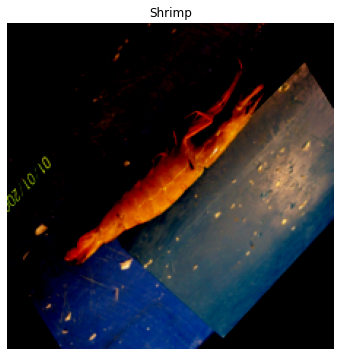

In [18]:
img, lab, img_name = dataset[4100]
plt.figure(figsize=(6, 6))
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(label_to_class[int(lab)])
plt.axis('off')
plt.show()

In [19]:
size = len(dataset)
print(f'Dataset size {size}')

Dataset size 9000


In [20]:
# test_set(len)

In [21]:
batch_size = 32
train_size = int(size * 0.8)
test_size = size - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=True)

In [22]:
test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=True)

In [23]:
batch_example = next(iter(train_loader))
print(f'Image batch size: {batch_example[0].shape}')
print(f'Label batch size: {batch_example[1].shape}')

Image batch size: torch.Size([32, 3, 224, 224])
Label batch size: torch.Size([32])


## Creating the Neural Network

In [24]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [25]:
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

In [26]:
def train(model, optimizer, criterion, epochs, train_loader, test_loader):
    loss_train, loss_test = [], []
    accuracy_train, accuracy_test = [], []

    for epoch in range(epochs):
        model.train()
        corrects = 0
        total = 0
        loss_list = []
        for images, labels, _ in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.max(outputs, 1)[1].to(DEVICE)

            total += len(labels)
            corrects += (predictions == labels).sum().item()
            loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        accuracy_train.append(100 * corrects / float(total))
        loss_train.append(np.mean(loss_list))

        model.eval()
        corrects = 0
        total = 0
        loss_list = []
        for images, labels, _ in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predict = torch.max(outputs.data, 1)[1].to(DEVICE)

            total += len(labels)
            corrects += (predict == labels).sum().item()
            loss_list.append(loss.item())

        accuracy_test.append(100 * corrects / float(total))
        loss_test.append(np.mean(loss_list))

        print(f"Epoch: {epoch + 1} | Train | Loss: {loss_train[-1]} | Accuracy: {accuracy_train[-1]}")
        print(f"Epoch: {epoch + 1} | Test | Loss: {loss_test[-1]} | Accuracy: {accuracy_test[-1]}\n")
    return accuracy_train, loss_train, accuracy_test, loss_test

### Simple CNN


In [27]:
class CNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(CNN, self).__init__()
        self.out_dim = out_dim
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 8, 8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=1, padding=0),
            nn.ReLU()
        )
        
        self.linear1 = nn.Linear(22 * 22 * 32, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, out_dim)
    
    def forward(self, x):
        conv = self.convs(x)
        flattened = conv.reshape(-1, 22 * 22 * 32)
        linear1 = F.relu(self.linear1(flattened))
        linear2 = self.linear2(linear1)
        out = self.linear3(linear2)
        return out

In [28]:
CUDA_LAUNCH_BLOCKING=1.

In [29]:
input_dim = dataset[0][0].shape[0] # number of channels (RGB - 3)
output_dim = len(classes) # number of classes
model = CNN(input_dim, output_dim).to(DEVICE)

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
# Запускать только при обучении моделей
# epochs = 8
# accuracy_train, loss_train, accuracy_test, loss_test = train(model, optimizer, criterion, epochs, train_loader, test_loader)

In [31]:
# torch.save(model.state_dict(), 'simple_cnn.pth')

In [32]:
# Загрузка весов модели
url = 'https://drive.google.com/uc?id=1ENDvYnc0A4Z3CHwVooqSDdKL9wMmuzC9'
output = 'simple_cnn.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ENDvYnc0A4Z3CHwVooqSDdKL9wMmuzC9
To: /content/simple_cnn.pth
100%|██████████| 16.0M/16.0M [00:00<00:00, 103MB/s] 


'simple_cnn.pth'

In [33]:
model.load_state_dict(torch.load('simple_cnn.pth')) 
model.eval()

CNN(
  (convs): Sequential(
    (0): Conv2d(3, 8, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
  (linear1): Linear(in_features=15488, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=9, bias=True)
)

## Find required examples

In [34]:
true_label = []
predicted_label = []
probits = []
for sample in tqdm(test_set):
    image, label, _ = sample
    predict = F.softmax(model(image[None, ...].to(DEVICE)), dim=1)
    true_label.append(int(label))
    predicted_label.append(np.argmax(predict.cpu().detach().numpy()))
    probits.append(predict.cpu().cpu().detach().numpy())

  0%|          | 0/1800 [00:00<?, ?it/s]

In [35]:
index = np.arange(1800)
probits_arr = np.vstack(probits)
true_label_arr = np.vstack(true_label)
predicted_label_arr = np.vstack(predicted_label)

In [36]:
np.random.seed(42)

In [37]:
correctly_classified = (true_label_arr == predicted_label_arr).reshape(-1)
correct_prob = probits_arr[correctly_classified]
corr_index = index[correctly_classified]

sorted_prob = np.argsort(correct_prob.max(axis=1))
max_index_corr = corr_index[np.random.choice(sorted_prob[-300:], 2)]
min_index_corr = corr_index[np.random.choice(sorted_prob[:100], 2)]

In [38]:
incorrectly_classified = (true_label_arr != predicted_label_arr).reshape(-1)
incorrect_prob = probits_arr[incorrectly_classified]
incorr_index = index[incorrectly_classified]

sorted_prob = np.argsort(incorrect_prob.max(axis=1))
max_index_incorr = incorr_index[np.random.choice(sorted_prob[-300:], 2)]
min_index_incorr = incorr_index[np.random.choice(sorted_prob[:100], 2)]

In [39]:
# Нужные примеры достаем из test_set
# test_set[max_index_corr[0]]

In [40]:
def print_examples(feature):
  for i in range(2):
    img, lab, img_name = test_set[feature[i]]
    image = Image.open(img_name)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.title(label_to_class[int(lab)])
    plt.axis('off')
    plt.show()

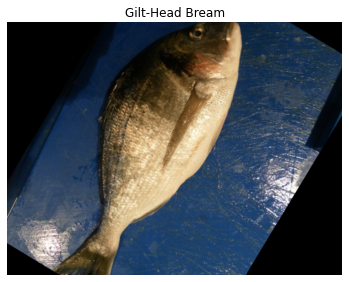

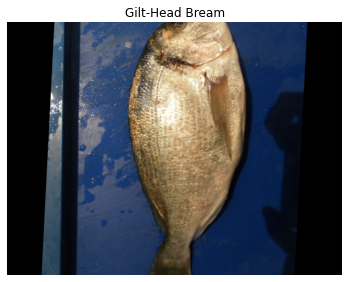

In [41]:
print_examples(max_index_corr)

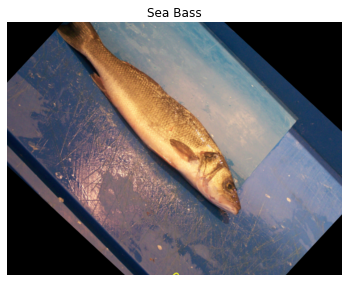

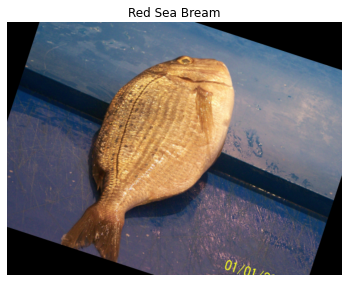

In [42]:
print_examples(max_index_incorr)

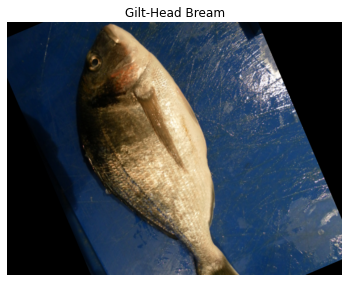

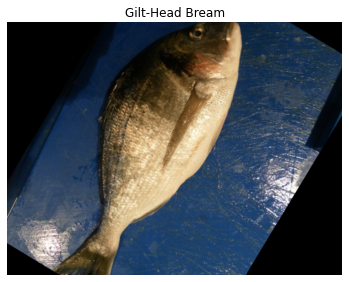

In [43]:
print_examples(min_index_corr)

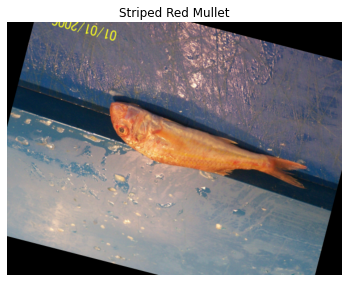

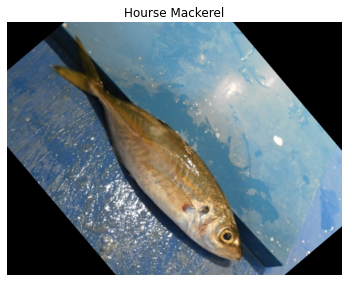

In [44]:
print_examples(min_index_incorr)

## SHAP values

In [45]:
batch_size = 1800
train_size = int(size * 0.8)
test_size = size - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=True)

In [46]:
batch = next(iter(test_loader))
images, lab, img_name = batch
images.size()

torch.Size([1800, 3, 224, 224])

In [47]:
images = images.cuda()

In [48]:
background = images[:500]
e = shap.DeepExplainer(model, background)
e

### Correct answers

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


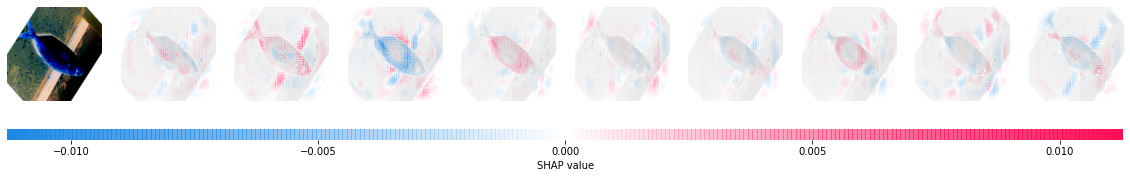

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


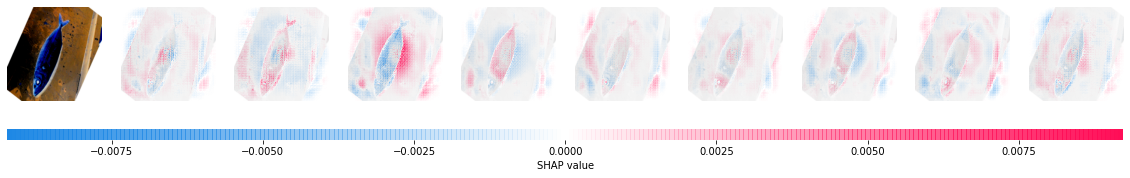

In [49]:
#min

for i in range(2):
  test_images = images[[min_index_corr[i]]]
  shap_values = e.shap_values(test_images)

  test_images=test_images.cpu()

  shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
  test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

  shap.image_plot(shap_numpy, -test_numpy)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


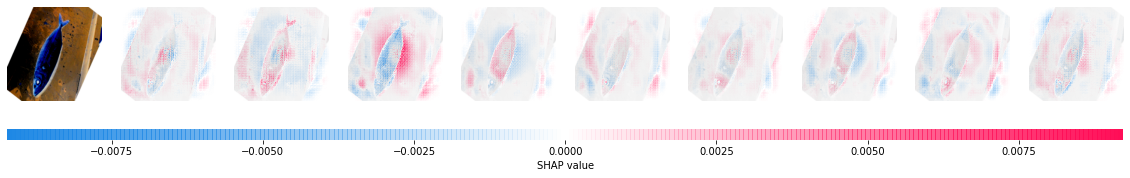

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


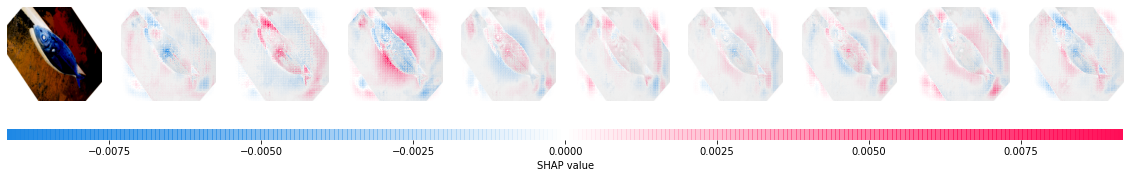

In [50]:
# max

for i in range(2):
  test_images = images[[max_index_corr[i]]]
  shap_values = e.shap_values(test_images)

  test_images=test_images.cpu()

  shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
  test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

  shap.image_plot(shap_numpy, -test_numpy)

### Incorrect answers

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


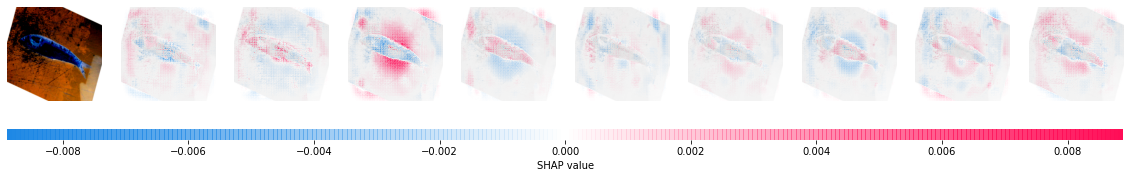

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


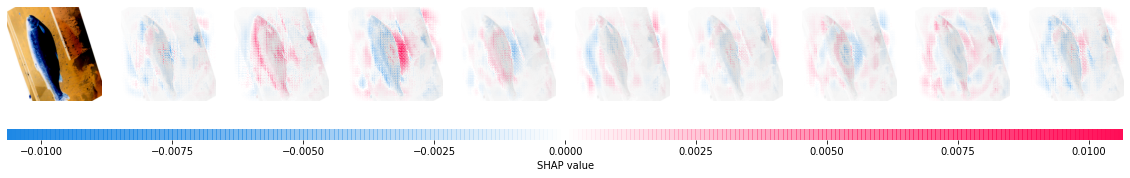

In [51]:
#min

for i in range(2):
  test_images = images[[min_index_incorr[i]]]
  shap_values = e.shap_values(test_images)

  test_images=test_images.cpu()

  shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
  test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

  shap.image_plot(shap_numpy, -test_numpy)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


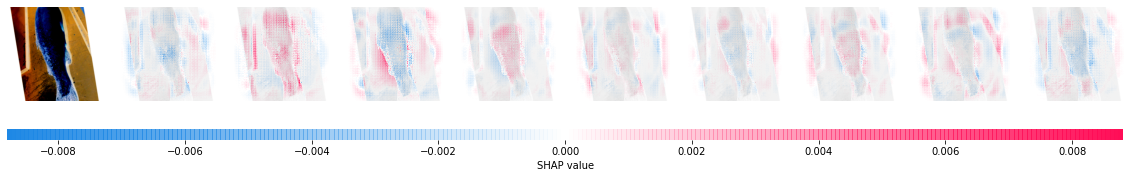

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


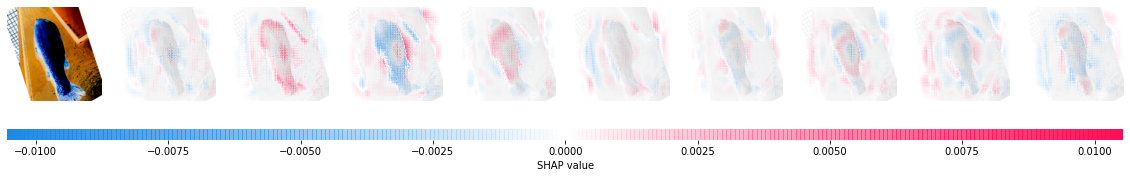

In [52]:
#max

for i in range(2):
  test_images = images[[max_index_incorr[i]]]
  shap_values = e.shap_values(test_images)

  test_images=test_images.cpu()

  shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
  test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

  shap.image_plot(shap_numpy, -test_numpy)

__Выводы:__ Картинки на графиках показывают, благодяря каким пикселям, модель разделяет картинку на тот или иной класс. На правильно угаданных объектах видные четкие очертания пикселей, благодаря чему определяется класс рыб. Можно отметить, что примеры с максимальной уверенность и минимальной не сильно отличаются друг от друга. Это может быть из-за высокой точности моделей. 

В примерах же, где модель ошиблась, видно, что нет однозначных очертаний, благодаря которым модель могла определить класс.